In [1]:
# 장르, 등급별 컬러 적용한 함수 만들기
# 1. 층, 블록 분포도 시각화
# 2. 전체 좌석 분포도 시각화
# 3. 해당 좌석정보들을 기준으로 빈 값들을 빈도순 and between 으로 채우고 => 그래도 남은 값들은 tran_rank 사용해서 채우는 함수

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

plt.rc('font', family = 'AppleGothic')
filterwarnings('ignore')

df = pd.read_csv("dataset/sac_ver02.csv")

In [3]:
def grade_byprice(df, place = '콘서트홀') :
    df_concert = df.query(f"`place` == '{place}'").sort_values(by='play')

    # 1. 가격, 할인율 정보가 있는 df만 선택해 작업
    df_paid = df_concert.query("`price`!= 0 & `discount_rate`!= -1 ")

    # 2. df_paid['price_org'] 생성(천의 자리에서 반올림)
    df_paid['price_org'] = round(((100 / (100 - df_paid['discount_rate'].astype(int))) * df_paid['price'].astype(int)).astype(int), -4)
    
    # 3. df_paid에 좌석등급을 채운 df_grade 생성 : play별로 grade 매기기 위해서 unique값 분리 후 리스트화
    play_list = df_paid.play.unique().tolist()

    # 4. df_grade 초기화 및 딕셔너리 설정
    df_grade = pd.DataFrame()
    grade_dic = {i: grade for i, grade in enumerate(['R', 'S', 'A', 'B', 'C'])}

    # 5. df_play 하나씩 등급 매기기
    for play in play_list : 
        
        # play 하나씩 순회
        df_play = df_paid[df_paid['play']==play]
        
        #price_org 높은 순부터 R,S,A,B,C 부여하기 위해서 sorted_list에는 5개만 담아두기
        sorted_list = sorted(df_play['price_org'].unique()[:5],reverse=True)

        #df_play['price_org']의 데이터를 sorted_list.index에서 찾았을 때 있으면 값 부여, 없으면 C 부여
        grades = df_play['price_org'].apply(lambda x: grade_dic[sorted_list.index(x)] if x in sorted_list else 'C')

        #grade col 생성
        df_play['grade'] = grades

        # df_grade에 하나씩 concat해서 업데이트
        df_grade = pd.concat([df_grade, df_play])
    return df_grade.sort_index()

In [4]:
def grade_heatmap(df, place = '콘서트홀', seat_grade = 'R', floorblock=True, all=True) :   
    # 0. 등급별 히트맵 컬러 지정
    Gcol = {'R':'Purples', 'S':'Greens', 'A':'Blues', 'B':'Oranges', 'C':'Greys'}

    # 1. place, seat_grade 인자에 따라 달라지게 설정
    df_place = df.query(f"`place` == '{place}'").sort_values(by='play')
    df_grade = df_place.query(f"`grade`=='{seat_grade}'")
    
    # 2. 층, 블록만 시각화(옵션)
    if floorblock == True : 
        # 2-1. 원본 데이터 pivot table 교차빈도값 획득 후 저장(->return)
        df_pivot_fb_raw = df_grade.pivot_table(index='seat_floor', columns='seat_block', aggfunc='size', fill_value=0) #size : 조합
        
        # 2-2. 시각화를 위한 처리 진행
        dfG = df_grade.copy()
        # seat_floor "층" 추가, 4층은 합창석으로 대체
        dfG['seat_floor'] = dfG['seat_floor'].astype(str) + "층"
        dfG['seat_floor'] = dfG['seat_floor'].replace("4층","합창석")
        # seat_block 길이가 1인 경우 "블록" 추가, seat_col "열" 추가
        dfG['seat_block'] = dfG['seat_block'].astype(str)
        dfG.loc[dfG['seat_block'].str.len() == 1, 'seat_block'] = dfG['seat_block'] + "블록"
        dfG['seat_col'] = dfG['seat_col'].astype(str).str.zfill(2) + "열"

        # 2-3. 편집된 dfG로 pivot_table화 및 값 정렬
        df_pivot_fb = dfG.pivot_table(index='seat_floor', columns='seat_block', aggfunc='size', fill_value=0) #size : 조합
        df_pivot_fb = df_pivot_fb.loc[['1층','2층','3층','합창석']] #row
        df_pivot_fb = df_pivot_fb[['BOX1','BOX2','BOX3','BOX7','BOX8','BOX9','A블록','B블록','C블록','D블록','E블록','F블록','G블록','H블록','BOX6','BOX5','BOX4','BOX12','BOX11','BOX10']] #col

        # 2-4. heatmap 그리기
        plt.figure(figsize=(25, 5))
        sns.heatmap(df_pivot_fb, annot=True, linewidths=1, linecolor='white', fmt='.0f', cmap=Gcol[seat_grade])

        plt.title(f"{seat_grade}등급 층, 블록 분포도", size=15, weight='bold') #제목
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(size=10)
        plt.yticks(size=10)
        plt.show()

    # 3. 전체 시각화(옵션)
    if all == True :
        # 3-1. 원본 데이터 pivot table 교차빈도값 획득 후 저장(->return)
        df_pivot_all_raw = df_grade.pivot_table(index=['seat_floor','seat_col'], columns=['seat_block','seat_num'], aggfunc='size', fill_value=0) 
        
        # 3-2. 시각화를 위한 처리 진행
        dfG = df_grade.copy()
        # seat_floor "층" 추가, 4층은 합창석으로 대체
        dfG['seat_floor'] = dfG['seat_floor'].astype(str) + "층"
        dfG['seat_floor'] = dfG['seat_floor'].replace("4층","합창석")
        # seat_block 길이가 1인 경우 "블록" 추가, seat_col "열" 추가
        dfG['seat_block'] = dfG['seat_block'].astype(str)
        dfG.loc[dfG['seat_block'].str.len() == 1, 'seat_block'] = dfG['seat_block'] + "블록"
        dfG['seat_col'] = dfG['seat_col'].astype(str).str.zfill(2) + "열"

        # 3-3. 편집된 dfG로 pivot_table화 및 값 정렬
        df_pivot_all = dfG.pivot_table(index=['seat_floor','seat_col'], columns=['seat_block','seat_num'], aggfunc='size', fill_value=0) #size : 조합
        seat_floor_order = ['1층','2층','3층','합창석']
        seat_block_order = ['BOX1','BOX2','BOX3','BOX7','BOX8','BOX9','A블록','B블록','C블록','D블록','E블록','F블록','G블록','H블록','BOX6','BOX5','BOX4','BOX12','BOX11','BOX10']
        df_pivot_all = df_pivot_all.loc[seat_floor_order, seat_block_order]

        # 3-4. 히트맵 그리기
        plt.figure(figsize=(110, 20))
        sns.heatmap(df_pivot_all, annot=True, annot_kws={"size": 10}, linewidths=0.1, linecolor='white', fmt='.0f', cmap=Gcol[seat_grade])

        plt.title(f"{seat_grade}등급 전체 좌석 분포도", size=50, weight='bold') #제목
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(size=10)
        plt.yticks(size=10)
        plt.show()


        return df_pivot_fb_raw, df_pivot_all_raw

# 함수 실행부

In [23]:
# 1. 콘서트홀 데이터에서 가격이 존재하는 데이터 기반으로 df_grade 생성
df_grade = grade_byprice(df, place = '콘서트홀')
df_grade.to_csv("df_grade.csv",index=False)

In [31]:
print("원본 데이터 수 : ", len(df))
print("콘서트홀 데이터 수: ", len(df.query("`place` == '콘서트홀'")))
print("콘서트홀에서 가격정보가 있는 데이터 수 : ",len(df_grade))

원본 데이터 수 :  1920301
콘서트홀 데이터 수:  1096860
콘서트홀에서 가격정보가 있는 데이터 수 :  503213


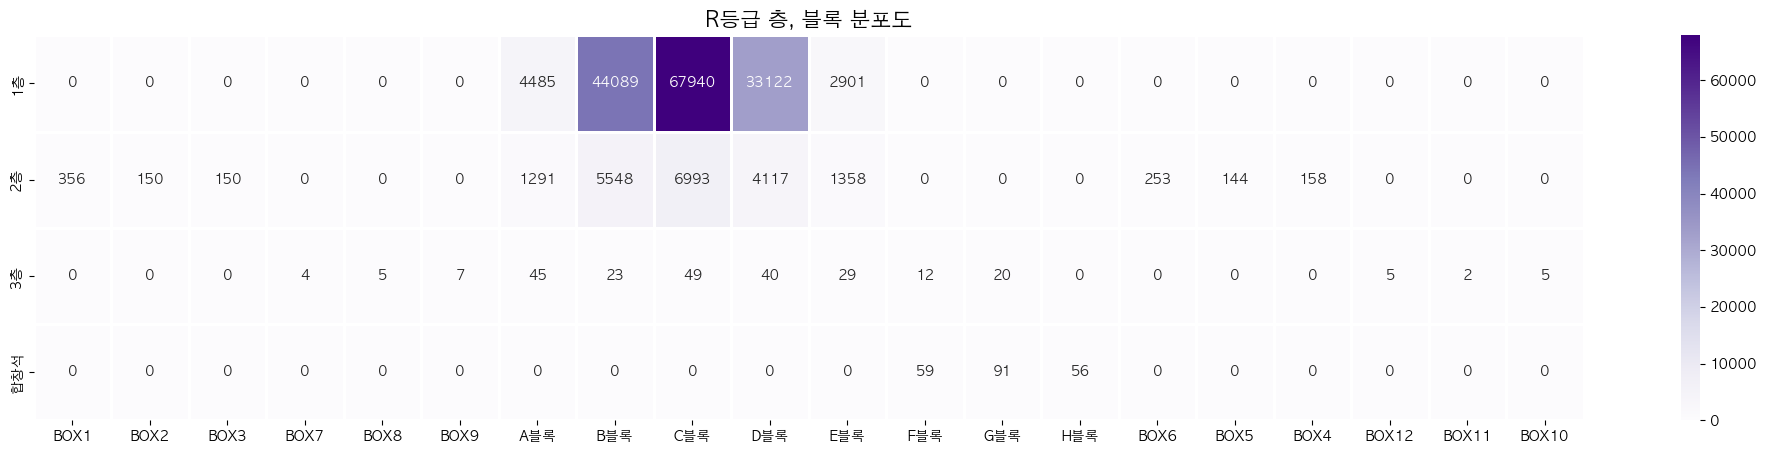

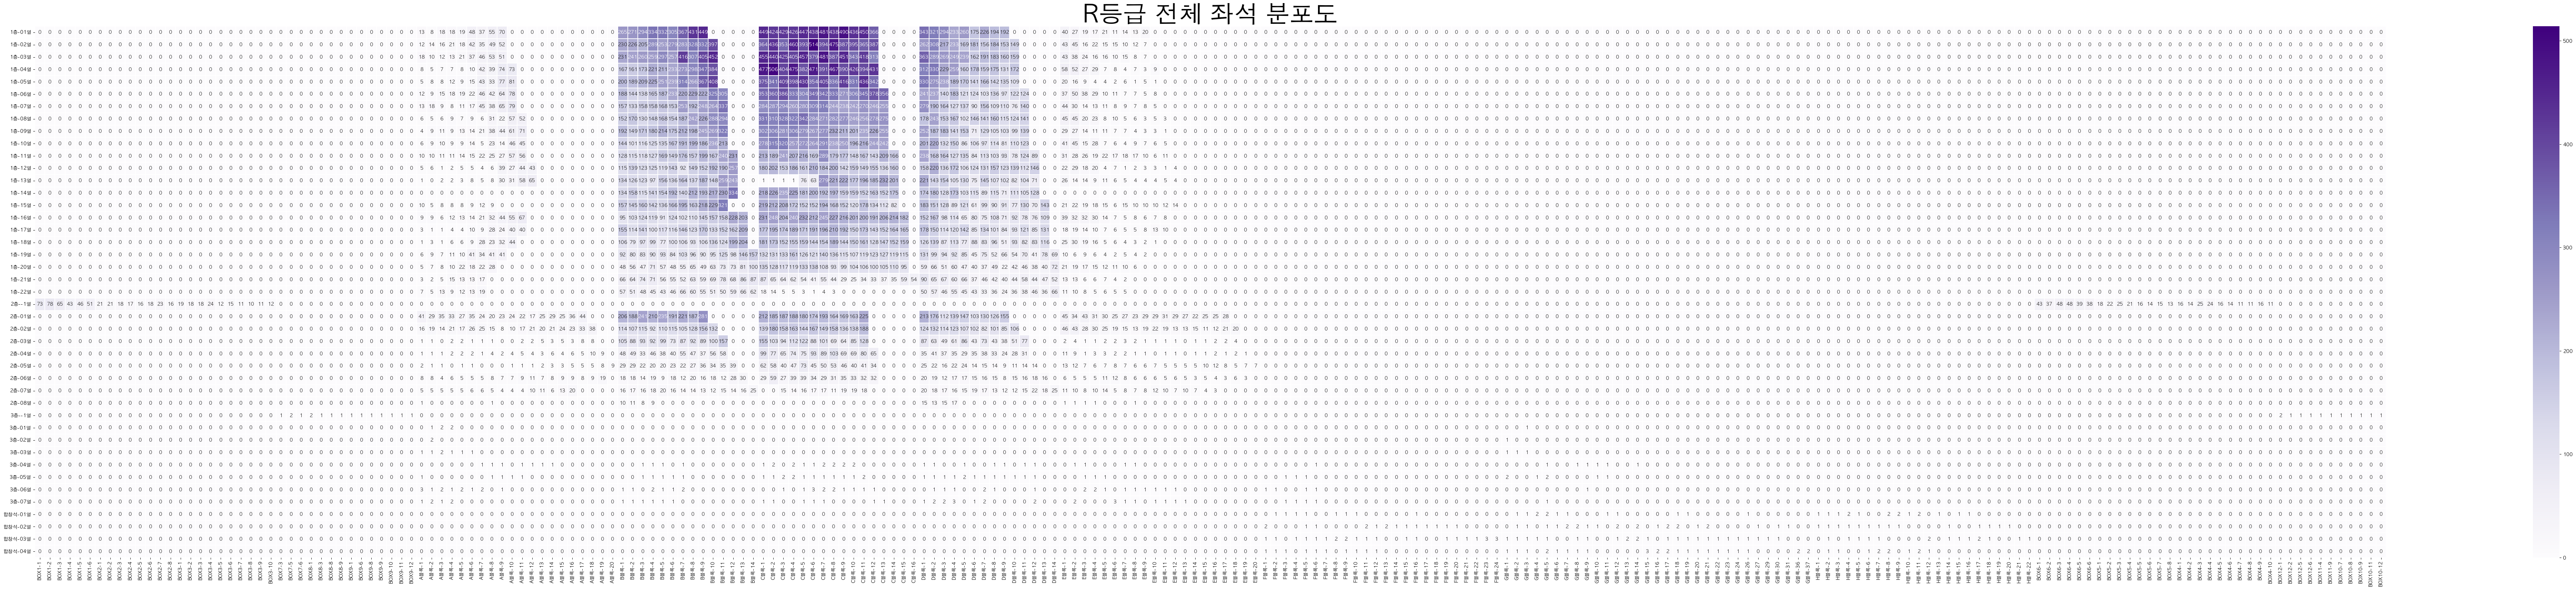

In [7]:
# 2. R,S,A,B,C 좌석 분포도 heatmap 시각화
_, R_pivot = grade_heatmap(df_grade, place = '콘서트홀', seat_grade = 'R', floorblock=True, all=True)

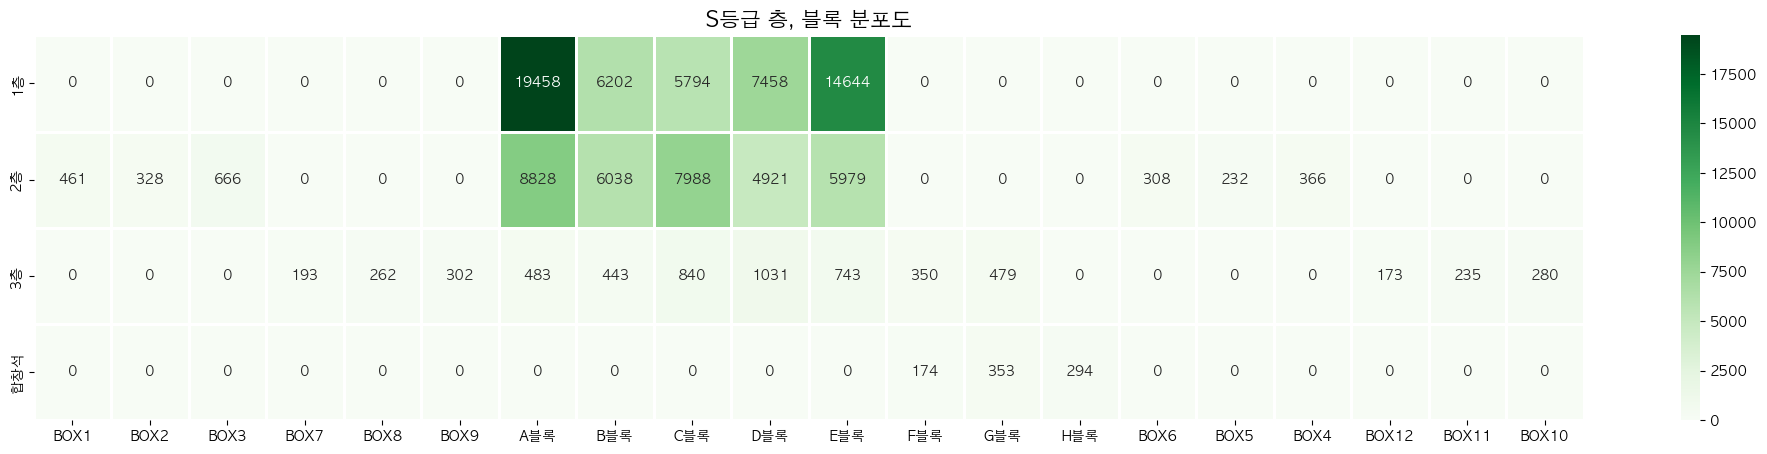

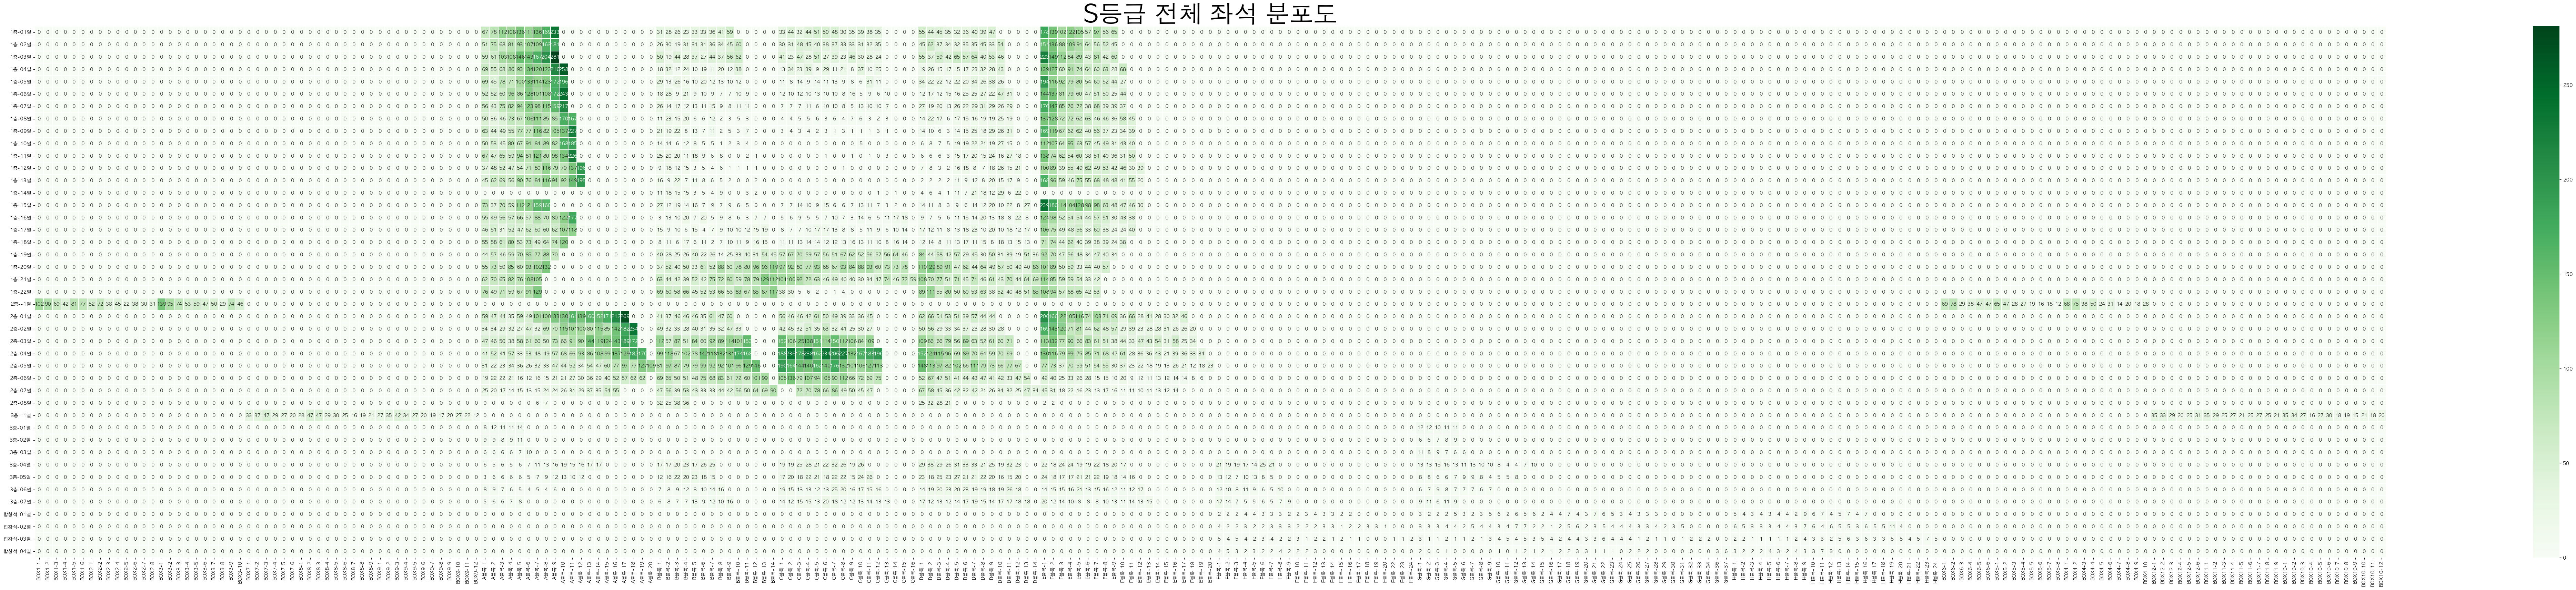

In [8]:
_, S_pivot = grade_heatmap(df_grade, place = '콘서트홀', seat_grade = 'S', floorblock=True, all=True)

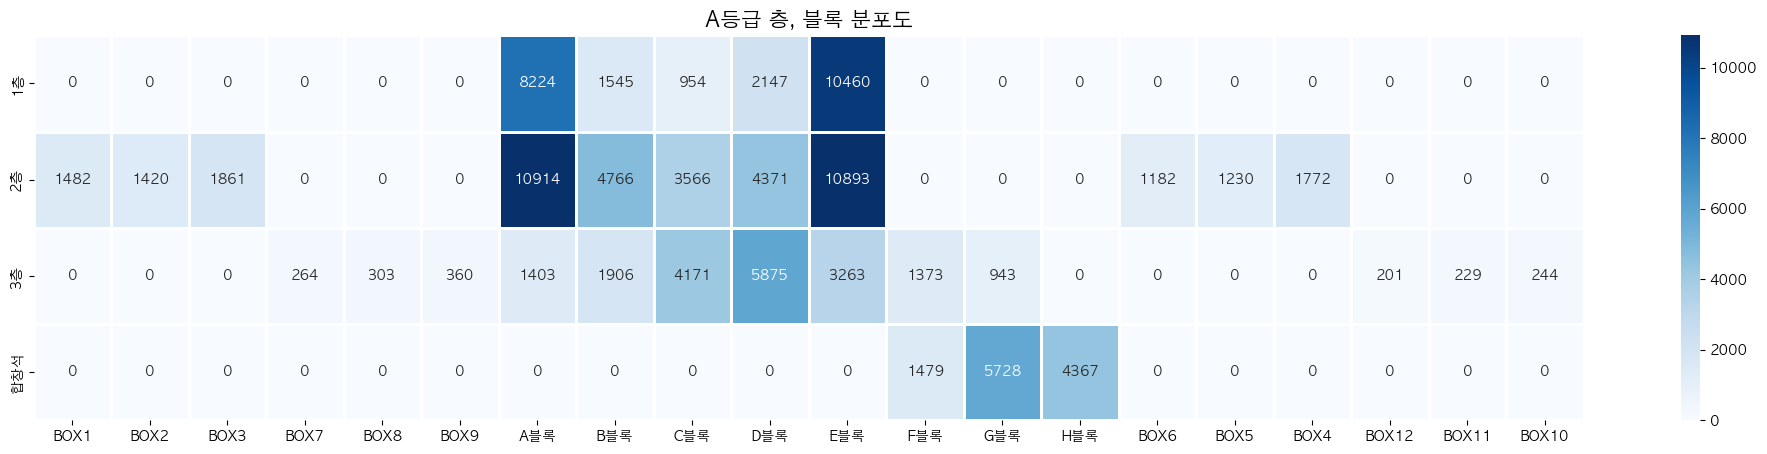

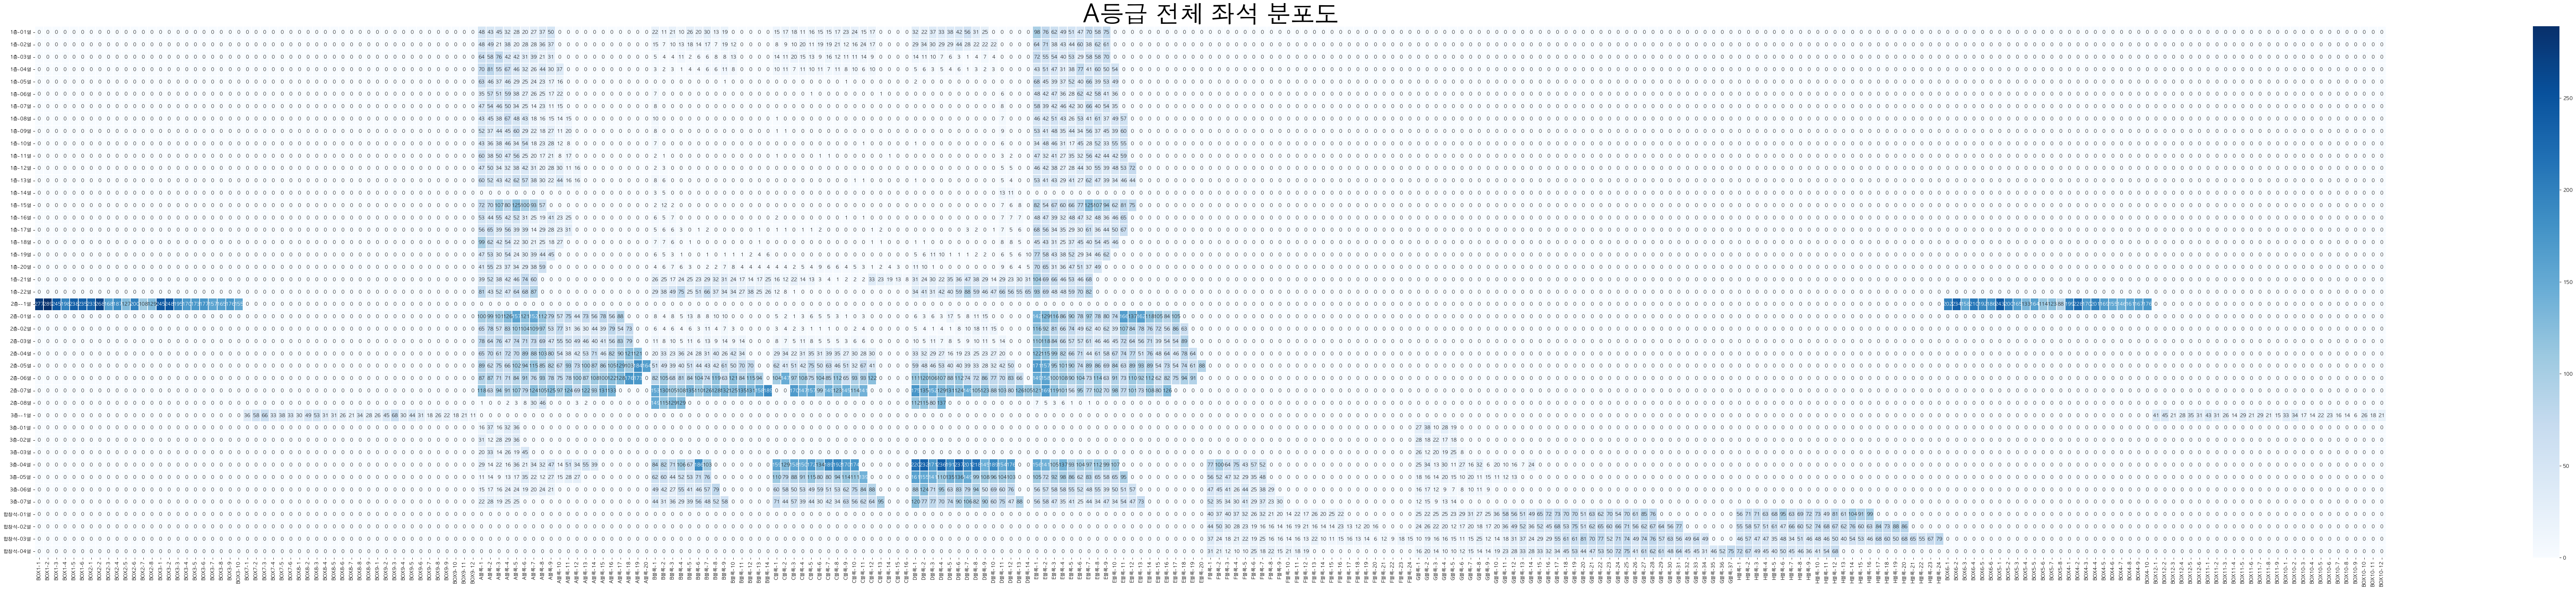

In [9]:
_, A_pivot = grade_heatmap(df_grade, place = '콘서트홀', seat_grade = 'A', floorblock=True, all=True)

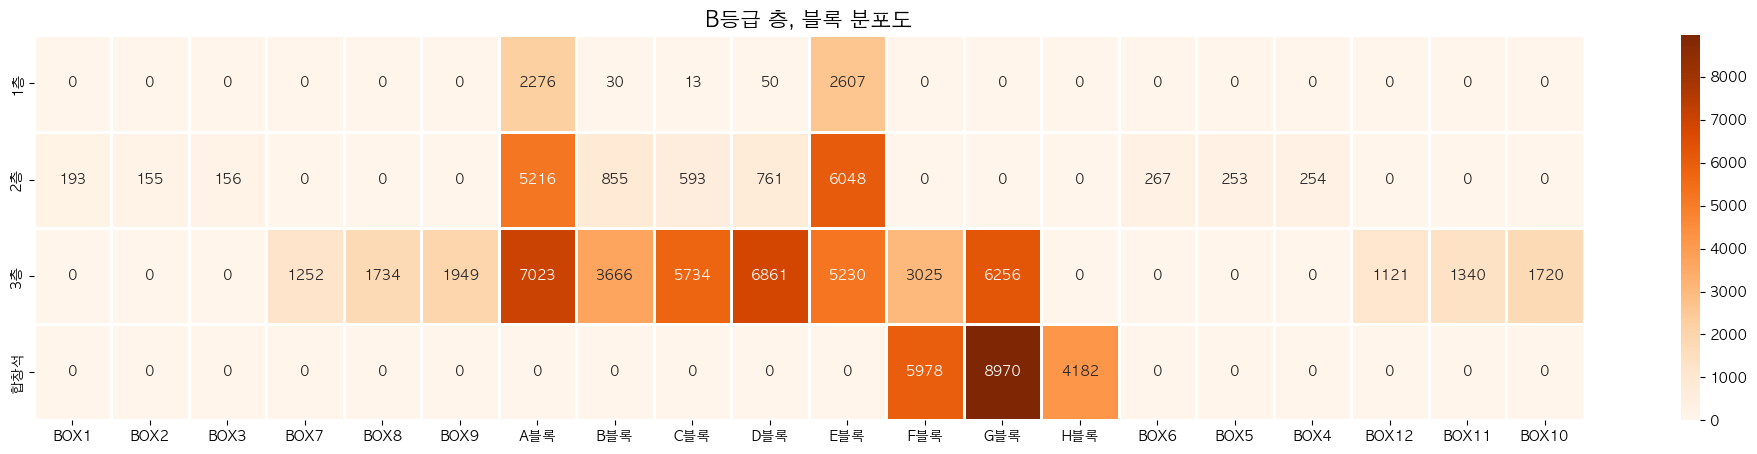

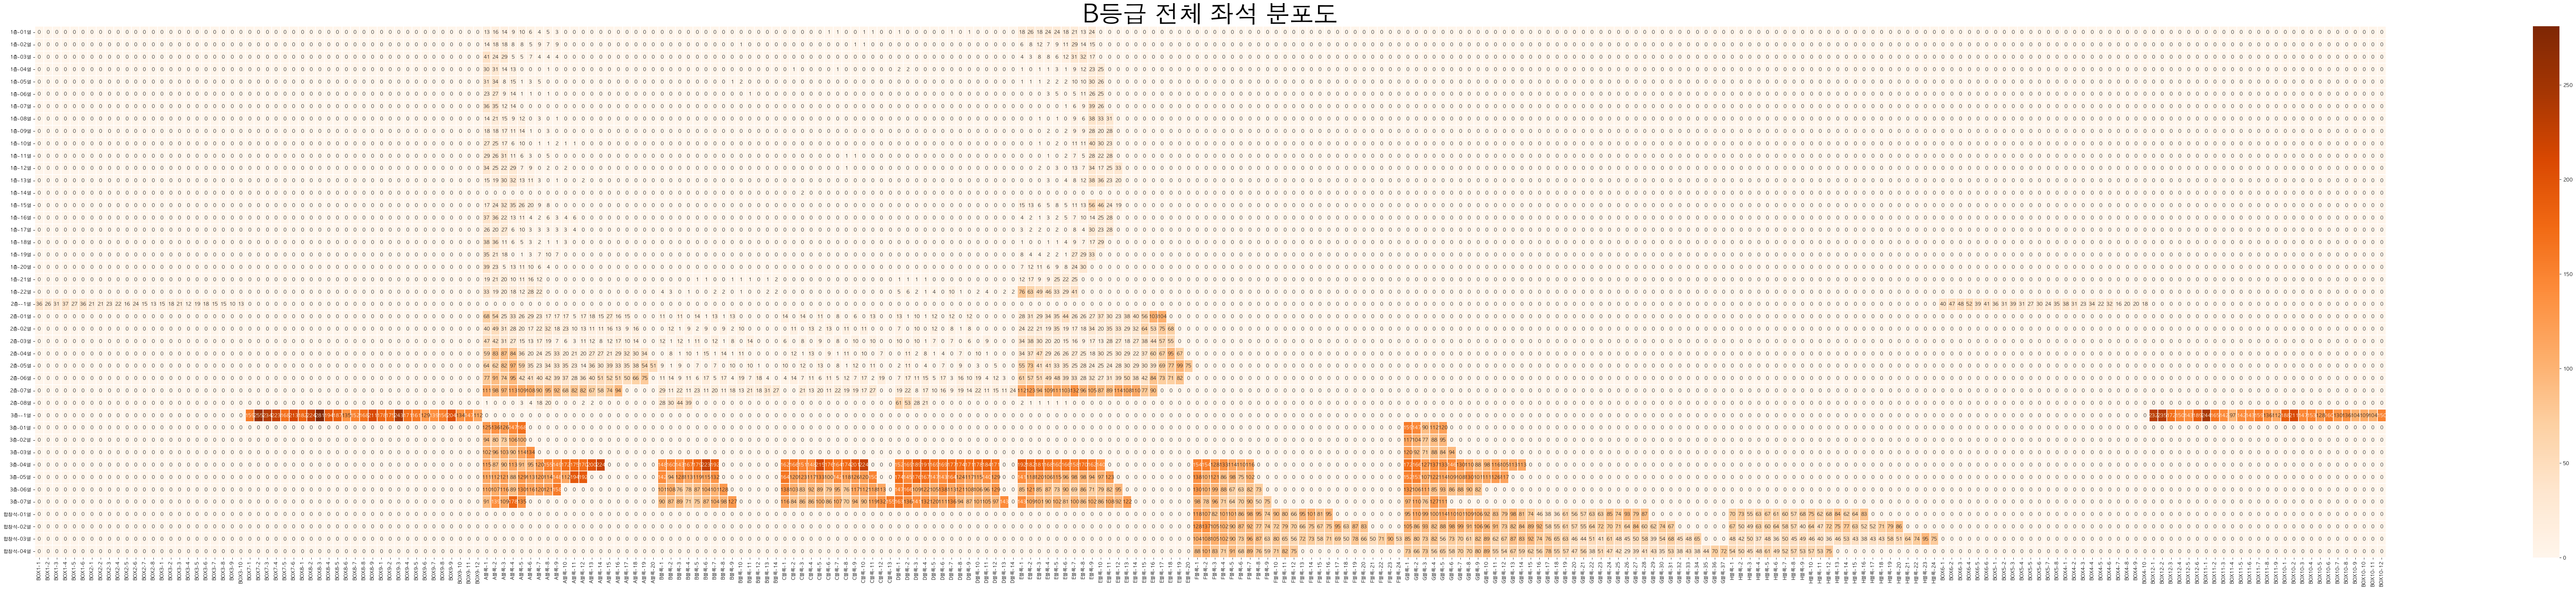

In [10]:
_, B_pivot = grade_heatmap(df_grade, place = '콘서트홀', seat_grade = 'B', floorblock=True, all=True)

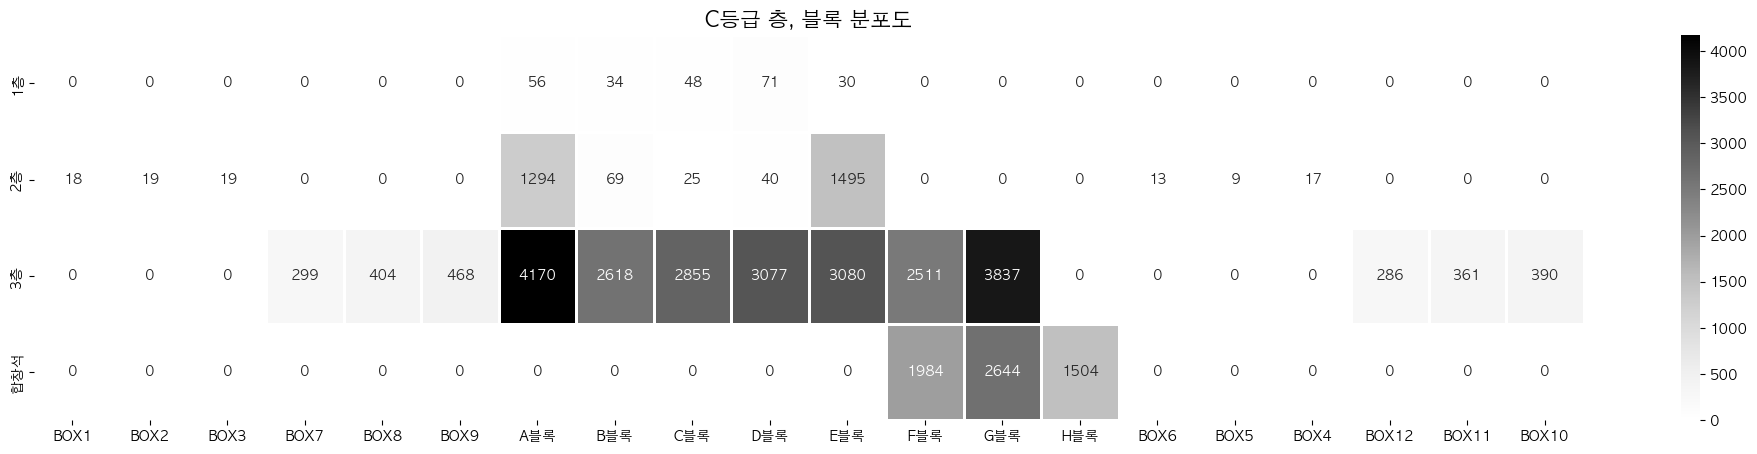

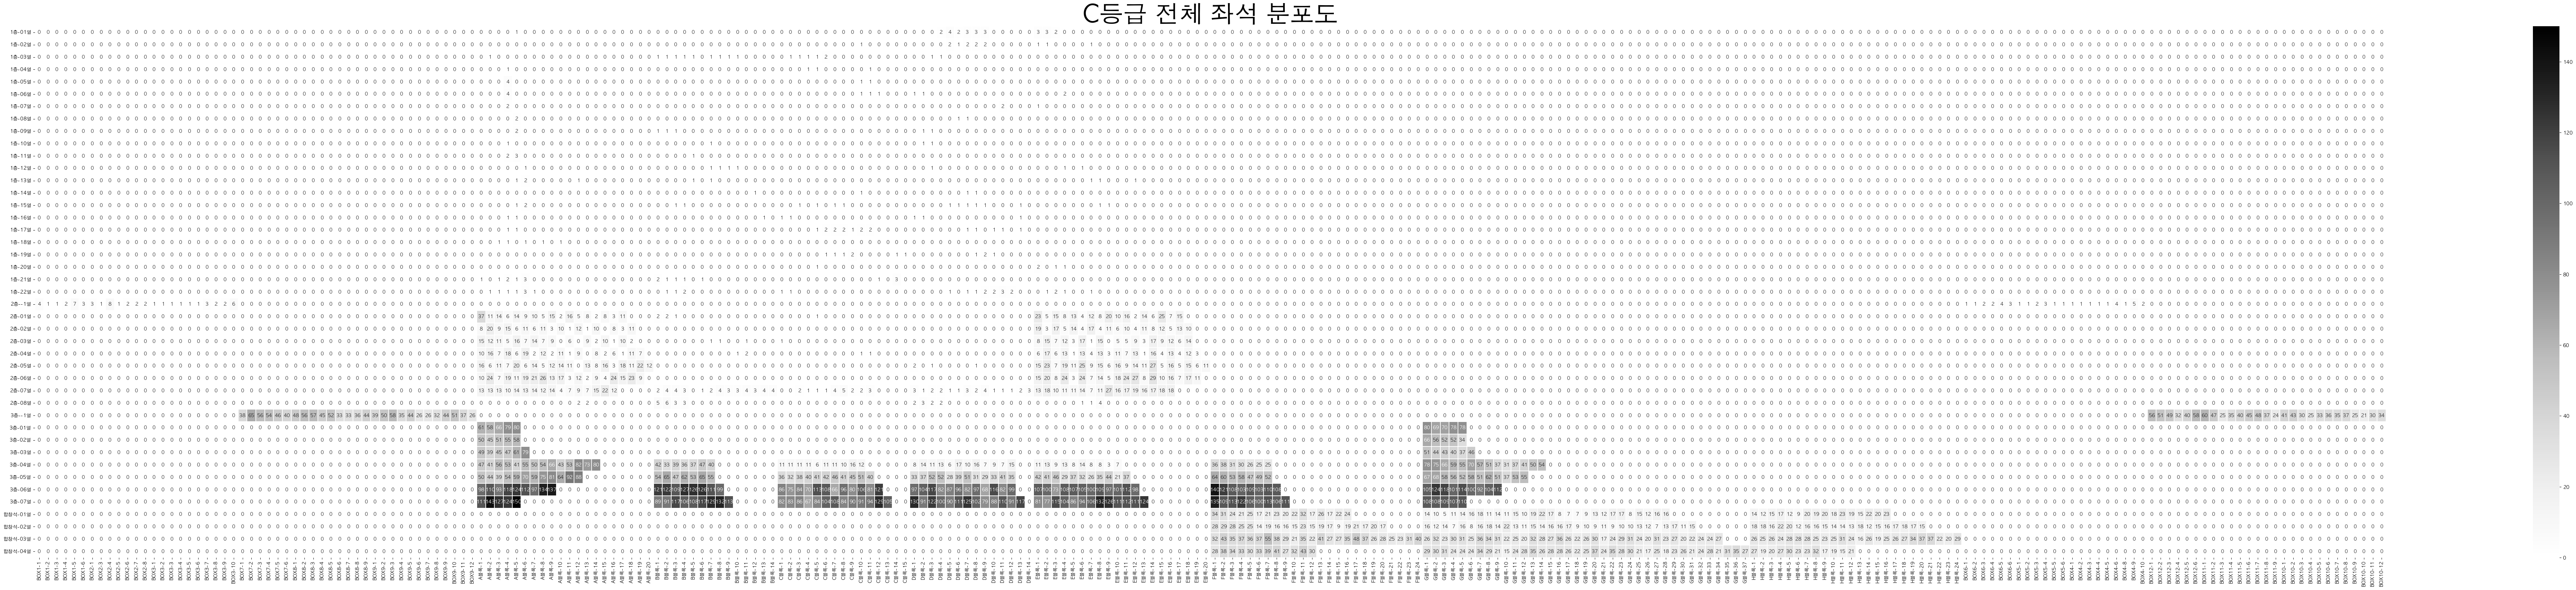

In [11]:
_, C_pivot = grade_heatmap(df_grade, place = '콘서트홀', seat_grade = 'C', floorblock=True, all=True)

In [119]:
# TEST중..
def grade_byseat(df, df_grade, df_pivot_all_raw, place = '콘서트홀', seat_grade = 'R') : # df=원본 전체, df_grade=grade가 매겨진 데이터프레임, df_pivot_all_raw =위의 함수에서 얻은 전체 데이터 피벗값
    df_concert = df.query(f"`place` == '{place}'")

    # 1. "지정한 등급에서", df_filled의 seat_floor, seat_block, seat_col, seat_num 정보를 확인해서 grade_count col 생성
    dfG_raw = df_grade.query(f"`grade`=='{seat_grade}'")
    dfG_raw['grade_count'] = dfG_raw.apply(lambda row: df_pivot_all_raw.at[(row['seat_floor'], row['seat_col']), (row['seat_block'], row['seat_num'])], axis=1)
    dfG_raw['grade'] = seat_grade

    # 2. df_grade를 기준으로 df_filled의 grade를 매길 예정
    df_filled = df_concert[~df_concert.isin(dfG_raw)].dropna()

    # 3. 초기값 설정 : grade_count의 '결측값' = 0, grade의 '결측값' = nan
    df_filled['grade_count'].fillna(0, inplace=True)
    df_filled['grade'].fillna(np.nan, inplace=True)

    dfG = pd.concat([dfG_raw, df_filled]).sort_index()
    dfG_fill = dfG.copy()

    # 4. 'seat_floor', 'seat_block', 'seat_col', 'seat_num' 열을 기준으로 데이터를 묶고, 각 그룹 내에서 'grade_count' 열의 최대값을 찾음
    max_grade_count = dfG_fill.groupby(['seat_floor', 'seat_block', 'seat_col', 'seat_num'])['grade_count'].transform('max')
    max_grade_count_values = max_grade_count.values

    #5. 각 그룹 내에서 기존 'grade_count' 값보다 더 크다면?  dfG_fill['grade']에 새로운 등급 부여
    dfG_fill['grade'] = dfG_fill.apply(lambda row: seat_grade if row['grade_count'] < max_grade_count[row.name] else row['grade'], axis=1)
    dfG_fill['grade_count'] = dfG_fill.apply(lambda row: max_grade_count[row.name] if row['grade_count'] < max_grade_count[row.name] else row['grade_count'], axis=1)

    # 6. 특정 등급 빈도가 평균 이상인 좌석 기준, BETWEEN에 위치한 값을 해당 등급으로 채우기
    # + Outer에 위치한 값은 tran_rank 가 평균 이상이면 해당 등급, 평균 이하면 하나 낮은 등급, C면 C를 부여하기.
    dfG_fill_between = pd.DataFrame() # 빈 리스트 생성

    # 6-1. floor별로 하나씩
    floor_list = dfG_fill.seat_floor.unique().tolist()
    for floor in floor_list:
        df_floor = dfG_fill.query(f"`seat_floor`=={floor}")
        # 6-2. block 별로 하나씩
        block_list = df_floor.seat_block.unique().tolist()
        for block in block_list:
            df_block = df_floor.query(f"`seat_block`=='{block}'")
            # 6-3. 변수 찾을 df_minmax 정의(임시용, 따로 저장X)
            df_minmax = df_block[(df_block['grade']==seat_grade) & (df_block['grade_count'] > df_block['grade_count'].mean())] # grade_count가 평균값 이상일 때만.
            
            max_col = df_minmax['seat_col'].max()
            min_col = df_minmax['seat_col'].min()
            max_num = df_minmax['seat_num'].max()
            min_num = df_minmax['seat_num'].min()

            # 6-4. df_block between, outer  처리
            # 6-4-1. 사이에 있는 경우, 해당 등급으로 채우기
            df_block_between = df_block[(min_col < df_block.loc[:,'seat_col']) & (df_block.loc[:,'seat_col'] < max_col) & (min_num < df_block.loc[:,'seat_num']) & (df_block.loc[:,'seat_num'] < max_num)]
            df_block_between['grade'] = seat_grade
            # 6-4-2. 바깥에 있는 경우.
            df_block_outer = df_block.loc[~df_block.index.isin(df_block_between.index)]
            # 6-4-3. tran_rank_good : 평균보다 빨리 예매된 경우 해당 등급을 부여
            df_tran_good = df_block_outer[df_block_outer['tran_rank'] > df_block_outer['tran_rank'].mean()]
            df_tran_good['grade'] = seat_grade
            # 6-4-4. tran_rank_bad : 평균보다 늦게 예매된 경우 한 단계 아래 등급을 부여
            df_tran_bad = df_block_outer[df_block_outer['tran_rank'] <= df_block_outer['tran_rank'].mean()]
            
            grade_dic = {i: grade for i, grade in enumerate(['R', 'S', 'A', 'B', 'C'])}

            if int(list(grade_dic.values()).index(seat_grade)) < 4 :
                df_tran_bad['grade'] = grade_dic[int(list(grade_dic.values()).index(seat_grade)) + 1]
            # C는 아래 등급이 없으므로 자기 자신 부여
            elif int(list(grade_dic.values()).index(seat_grade)) == 4 :
                df_tran_bad['grade'] = seat_grade
            else :
                df_tran_bad['grade'] = df_tran_bad['grade']

            # 7. 데이터프레임에 채우기    
            dfG_fill_between = pd.concat([dfG_fill_between, df_block_between])
    dfG_fill_byseat = pd.concat([dfG_fill_between,df_concert[~df_concert.isin(dfG_fill_between)].dropna()])
    dfG_fill_byseat[['grade_count','seat_floor','seat_col','seat_num']] = dfG_fill_byseat[['grade_count','seat_floor','seat_col','seat_num']].astype(int)
    
    return dfG_fill_byseat.sort_index()  # 선택한 홀의 df만

In [120]:
# 3. 주의 : R->S->A->B->C 순으로 실행할 것!
dfR = grade_byseat(df, df_grade, R_pivot, place = '콘서트홀', seat_grade = 'R')
print((len(dfR)))
dfR

173564


age  gender     price  ticket_cancel  performance_code  \
4        50.0     0.0  180000.0            0.0             897.0   
15       30.0     1.0  130000.0            0.0            1684.0   
27       20.0     1.0   66000.0            0.0             221.0   
28       50.0     1.0   88000.0            0.0             221.0   
37       40.0     0.0   99000.0            2.0            2538.0   
...       ...     ...       ...            ...               ...   
1920207  60.0     1.0   65000.0            2.0             834.0   
1920225  20.0     0.0   49000.0            0.0             289.0   
1920227  -1.0    -1.0   50000.0            2.0            2837.0   
1920233  20.0     1.0   35000.0            0.0             183.0   
1920275  50.0     1.0  142000.0            2.0            1789.0   

         pre_open_date   open_date genre place  running_time  ...  seat_block  \
4                  1.0  2022-01-10    독주  콘서트홀          90.0  ...           B   
15                 1.0  2023-02-19    합창  콘서트홀         100.0  ...           C   
27                 1.0  2023-02-26   클래식  콘서트홀         150.0  ...           B   
28                 1.0  2023-02-26   클래식  콘서트홀         150.0  ...           B   
37                 1.0  2021-07-03   클래식  콘서트홀         110.0  ...           C   
...                ...         ...   ...   ...           ...  ...         ...   
1920207            1.0  2022-11-19    독주  콘서트홀         120.0  ...           B   
1920225            0.0  2019-12-09   교향곡  콘서트홀         120.0  ...           B   
1920227            0.0  2019-03-23   교향곡  콘서트홀         120.0  ...           C   
1920233            1.0  2022-01-22   교향곡  콘서트홀         100.0  ...           C   
1920275            1.0  2022-04-11    독주  콘서트홀          95.0  ...           C   

         seat_col seat_num             discount_name discount_rate  \
4              12        7                        일반           0.0   
15              2        2                        일반           0.0   
27             21        9                   싹틔우미 할인          40.0   
28             17        4  라흐마니노프탄생150주년(8매/3.27까지)          20.0   
37             15        8                   골드회원 할인          10.0   
...           ...      ...                       ...           ...   
1920207         9        2          장애인할인(1~3급/동반1인)          50.0   
1920225         4        5          초/중/고등학생 할인(본인만)          30.0   
1920227         2        6                        일반           0.0   
1920233         9        9         초,중,고,대학(원)생(본인만)          50.0   
1920275         5        9                   그린회원 할인           5.0   

        membership_free  membership_paid  price_org grade  grade_count  
4                    일반               무료   180000.0     R           92  
15                   일반               그린   130000.0     R          436  
27                 싹틔우미               무료   110000.0     R           59  
28                   일반               블루   110000.0     R          100  
37                   일반               골드   110000.0     R          168  
...                 ...              ...        ...   ...          ...  
1920207              일반               그린   130000.0     R          149  
1920225            싹틔우미               골드    70000.0     R           38  
1920227             비회원              비회원    50000.0     R          514  
1920233            싹틔우미               무료    70000.0     R          211  
1920275              일반               그린   150000.0     R          416  

[173564 rows x 28 columns]

In [122]:
dfS = grade_byseat(dfR, df_grade, S_pivot, place = '콘서트홀', seat_grade = 'S')
print((len(dfS)))
dfS.grade.value_counts()

211391


grade
S    146316
R     65075
Name: count, dtype: int64

In [123]:
dfA = grade_byseat(dfS, df_grade, A_pivot, place = '콘서트홀', seat_grade = 'A')
print((len(dfA)))
dfA.grade.value_counts()

251196


grade
A    136090
R     61636
S     53470
Name: count, dtype: int64

In [124]:
dfB = grade_byseat(dfA, df_grade, B_pivot, place = '콘서트홀', seat_grade = 'B')
print((len(dfB)))
dfB.grade.value_counts()

284369


grade
B    112786
R     61533
A     58937
S     51113
Name: count, dtype: int64

In [125]:
dfC = grade_byseat(dfB, df_grade, C_pivot, place = '콘서트홀', seat_grade = 'C')
print((len(dfC)))
dfC.grade.value_counts()

291832


grade
C    94987
B    66772
R    61531
A    37626
S    30916
Name: count, dtype: int64